In [1]:
!pip install imutils
# !pip install -U torchvision
#!pip install torchsummary

^C


In [3]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import random
import xml.etree.ElementTree as ET 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torchsummary import summary

In [4]:
print(torchvision.__version__)

0.10.1+cpu


<span style="font-size:25px;">**Check if GPU is available**</span>

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


<span style="font-size:25px;">**Display example data**</span>

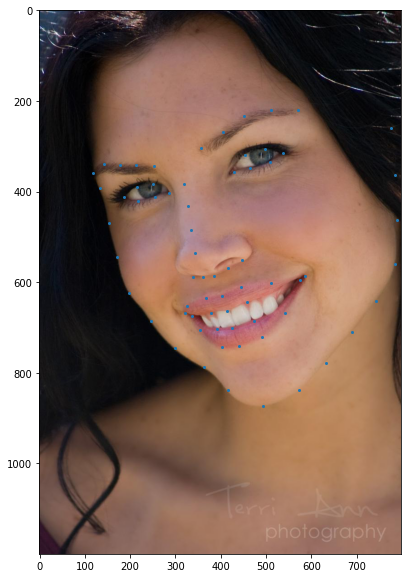

In [6]:
file = open('../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 4)
plt.show()

<span style="font-size:25px;">**Data preprocessing**</span>

To prevent the neural network from overfitting the training dataset, the dataset is transoformed randomly. The following operations are applied to the training and validation dataset:
* Since the face occupies a very small portion of the entire image, crop the image and use only the face for training.
* Resize the cropped face into a (224x224) image.
* Randomly change the brightness and saturation of the resized face.
* Randomly rotate the face after the above three transformations.
* Convert the image and landmarks into torch tensors and normalize them between [-1, 1].

In [ ]:
class Transforms():
    def __init__(self):
        pass
    
    def crop_face(self, image, landmarks, crops):
        top = int(crops['top'])
        left = int(crops['left'])
        height = int(crops['height'])
        width = int(crops['width'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks
    
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks
    
    def color_jitter(self, image, landmarks):
        #ranNum = random.random()
        color_jitter = transforms.ColorJitter(brightness=random.random(), 
                                              contrast=random.random(),
                                              saturation=random.random(), 
                                              hue=random.uniform(0,0.5))
        image = color_jitter(image)
        return image, landmarks
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks
    
    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=random.randint(-20,20))
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

<span style="font-size:25px;">**Dataset Preparation**</span>

The labels_ibug_300W_train.xml contains the image path, landmarks and coordinates for the bounding box. Store these values in lists to access them easily during training.

In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):
        tree = ET.parse('../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = '../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

OriDataset = FaceLandmarksDataset()

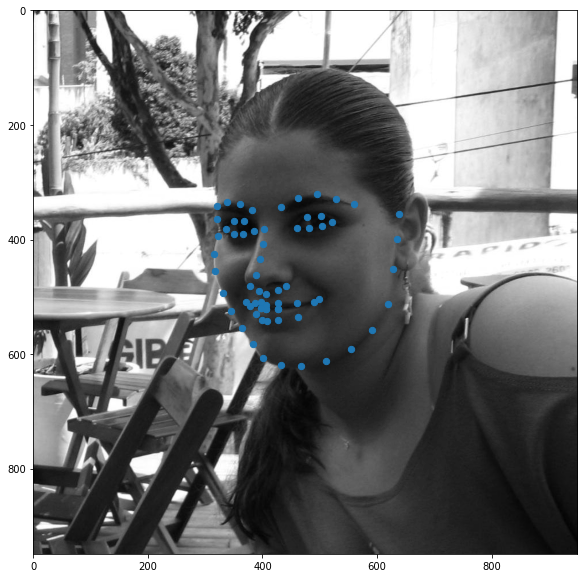

In [8]:
image, landmarks = OriDataset[150]
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=40);

<span style="font-size:25px;">**Example of image after pre-processing**</span>

In [11]:
!pip install dlib
import dlib

In [23]:
detector = dlib.get_frontal_face_detector()
predictor_path = "/kaggle/input/dlib68/gemmacpp/default/1/shape_predictor_68_face_landmarks.dat"  # Make sure you have this file
predictor = dlib.shape_predictor(predictor_path)
path="/kaggle/input/ibug-300w-large-face-landmark-dataset"

# 设置数据集路径 - 请根据您的实际路径调整
DATASET_BASE = '../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset'

# 加载dlib的面部检测器和标志点预测器


# 检查预测器文件是否存在
if not os.path.exists(predictor_path):
    print(f"错误: 找不到预测器文件 {predictor_path}")
    print("请从 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 下载并解压")
    exit(1)

predictor = dlib.shape_predictor(predictor_path)

# 读取标志点文件的函数
def read_pts_file(file_path):
    with open(file_path) as file:
        points = file.readlines()[3:-1]  # 跳过头部和尾部行
    
    landmarks = []
    for point in points:
        x, y = point.split(' ')
        landmarks.append([floor(float(x)), floor(float(y[:-1]))])
    
    return np.array(landmarks)

# 将dlib的标志点转换为numpy数组
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

# 计算平均误差
def calculate_error(pred_landmarks, gt_landmarks):
    # 确保两者形状相同
    assert pred_landmarks.shape[0] == gt_landmarks.shape[0], "标志点数量不匹配"
    
    # 计算每个标志点的欧氏距离
    distances = np.sqrt(np.sum((pred_landmarks - gt_landmarks)**2, axis=1))
    
    # 返回平均误差和各点误差
    return np.mean(distances), distances

# 计算眼间距(用于归一化)
def calculate_iod(landmarks):
    # 对于68点标志, 36-41是右眼, 42-47是左眼
    right_eye_center = np.mean(landmarks[36:42], axis=0)
    left_eye_center = np.mean(landmarks[42:48], axis=0)
    return np.linalg.norm(right_eye_center - left_eye_center)

# 验证单个图像
def verify_single_image(img_path, pts_path):
    # 读取图像
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"无法读取图像: {img_path}")
        return None
    
    # 读取地面真值标志点
    gt_landmarks = read_pts_file(pts_path)
    
    # 转换为灰度图像
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 检测人脸
    faces = detector(gray, 1)
    
    if len(faces) == 0:
        print(f"未检测到人脸: {img_path}")
        return None
    
    # 使用第一个检测到的人脸
    face = faces[0]
    
    # 预测标志点
    shape = predictor(gray, face)
    pred_landmarks = shape_to_np(shape)
    
    # 计算误差
    mean_error, point_errors = calculate_error(pred_landmarks, gt_landmarks)
    
    # 计算归一化误差(以眼间距为基准)
    iod = calculate_iod(gt_landmarks)
    normalized_error = mean_error / iod
    
    # 可视化结果
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 原始图像
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('original img')
    axes[0].axis('off')
    
    # 地面真值标志点
    axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[1].scatter(gt_landmarks[:, 0], gt_landmarks[:, 1], c='g', s=20, marker='o')
    axes[1].set_title('true value of landmarks')
    axes[1].axis('off')
    
    # dlib预测结果
    axes[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[2].scatter(pred_landmarks[:, 0], pred_landmarks[:, 1], c='r', s=20, marker='o')
    axes[2].set_title(f'Dlib predict result (error: {mean_error:.2f}pixel, normalize error: {normalized_error*100:.2f}%)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean_error': mean_error,
        'normalized_error': normalized_error,
        'point_errors': point_errors,
        'iod': iod,
        'gt_landmarks': gt_landmarks,
        'pred_landmarks': pred_landmarks
    }

# 批量验证
def batch_verification(subset_dir, n_samples=5):
    subset_path = Path(DATASET_BASE) / subset_dir
    
    # 获取所有图像文件
    img_files = list(subset_path.glob('*.jpg')) + list(subset_path.glob('*.png'))
    
    if not img_files:
        print(f"在 {subset_path} 中未找到图像文件")
        return
    
    # 如果样本数大于可用图像数，则减少样本数
    n_samples = min(n_samples, len(img_files))
    
    # 随机选择样本
    import random
    random.shuffle(img_files)
    sample_files = img_files[:n_samples]
    
    results = []
    
    for img_file in sample_files:
        pts_file = img_file.with_suffix('.pts')
        
        if not pts_file.exists():
            print(f"找不到对应的标志点文件: {pts_file}")
            continue
        
        print(f"处理: {img_file.name}")
        result = verify_single_image(img_file, pts_file)
        
        if result:
            results.append(result)
    
    # 计算总体统计信息
    if results:
        mean_errors = [r['mean_error'] for r in results]
        norm_errors = [r['normalized_error'] for r in results]
        
        print("\n=====stat result=====")
        print(f"sample number: {len(results)}")
        print(f"average pixel error: {np.mean(mean_errors):.2f} ± {np.std(mean_errors):.2f}")
        print(f"average normalize error: {np.mean(norm_errors)*100:.2f}% ± {np.std(norm_errors)*100:.2f}%")
        
        # 绘制误差分布
        plt.figure(figsize=(10, 6))
        plt.hist(norm_errors, bins=10)
        plt.xlabel('normalize error')
        plt.ylabel('freq')
        plt.title('Dlib points normalization error distribution')
        plt.show()
    
    return results

# 验证指定的单一图像
def verify_specific_image():
    img_path = '../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.jpg'
    pts_path = '../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/testset/2986046144_1.pts'
    
    print(f"verify samples: {os.path.basename(img_path)}")
    result = verify_single_image(img_path, pts_path)
    
    if result:
        print(f"mean pixel error: {result['mean_error']:.2f}")
        print(f"normalize error: {result['normalized_error']*100:.2f}%")
        print(f"eye distance: {result['iod']:.2f} pixel")
    
    return result

# 主函数
def main():
    print("Dlib result")
    print("=" * 40)
    
    # 首先验证特定的图像
    verify_specific_image()
    
    # 然后随机验证多个数据子集
    subsets = [
        'helen/testset',
        'helen/trainset',
        'lfpw/testset',
        'lfpw/trainset',
        'ibug'
    ]
    
    for subset in subsets:
        print(f"\n subset verification: {subset}")
        batch_verification(subset, n_samples=3)


Dlib result
verify samples: 2986046144_1.jpg


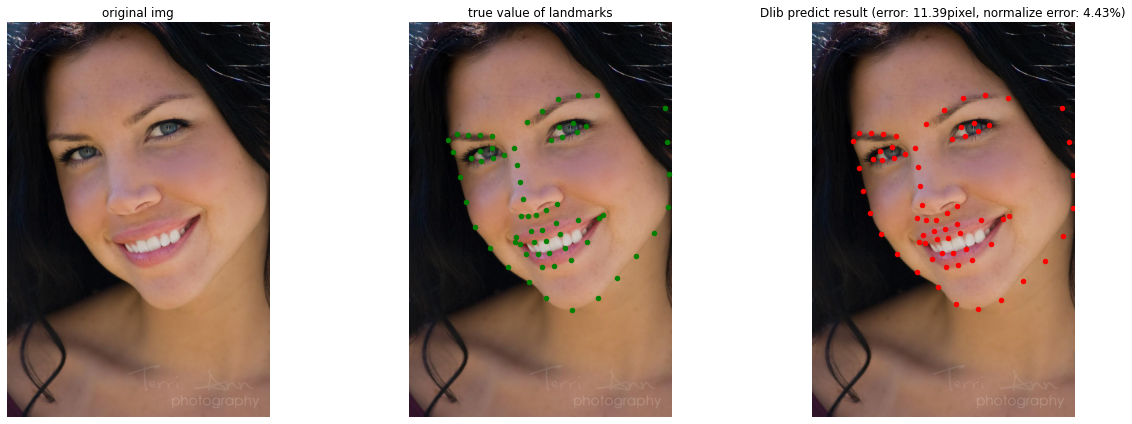

mean pixel error: 11.39
normalize error: 4.43%
eye distance: 257.32 pixel

 subset verification: helen/testset
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/testset/3036412907_4_mirror.pts
处理: 3252851380_1.jpg


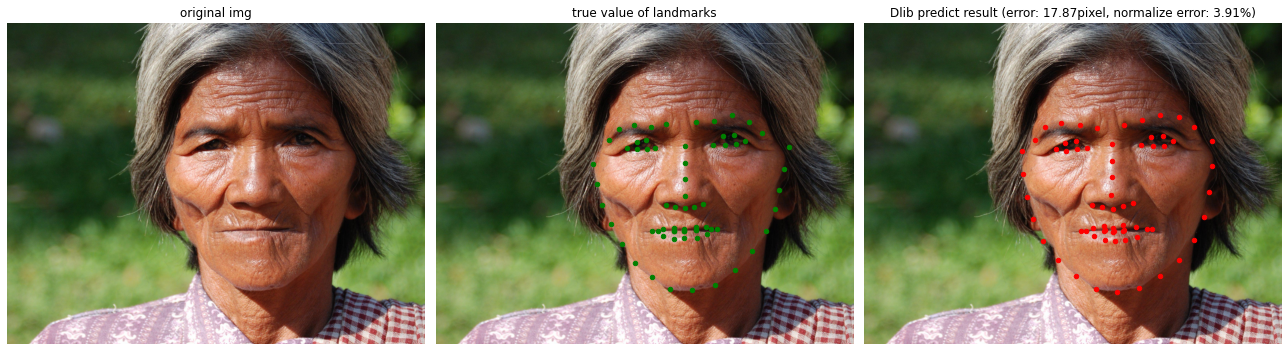

处理: 302148352_1.jpg


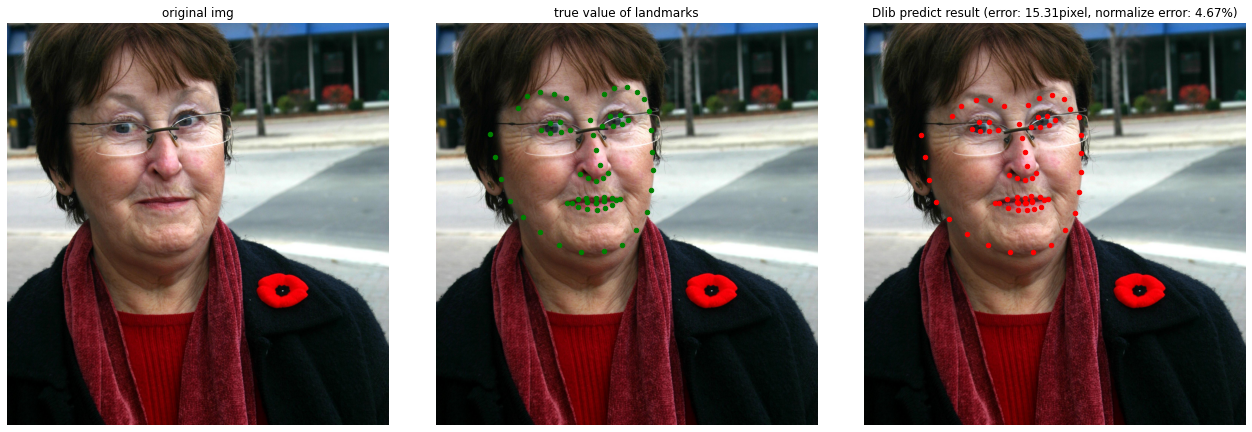


=====stat result=====
sample number: 2
average pixel error: 16.59 ± 1.28
average normalize error: 4.29% ± 0.38%


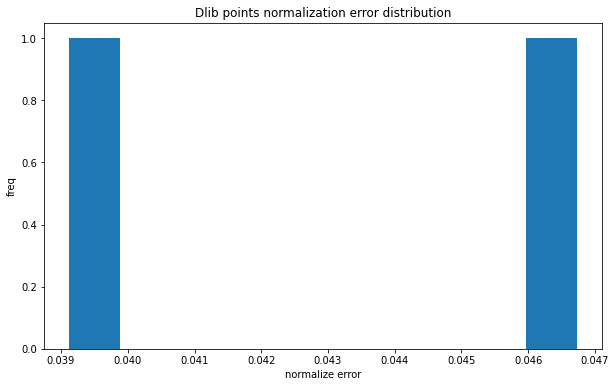


 subset verification: helen/trainset
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/trainset/2891259033_1_mirror.pts
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/trainset/2401967202_1_mirror.pts
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/trainset/2540799498_1_mirror.pts

 subset verification: lfpw/testset
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/lfpw/testset/image_0123_mirror.pts
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/lfpw/testset/image_0052_mirror.pts
找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/lfpw/testset/image_0060_mirror.pts

 subset verification: lfpw/trainset
处理: image_0379.png


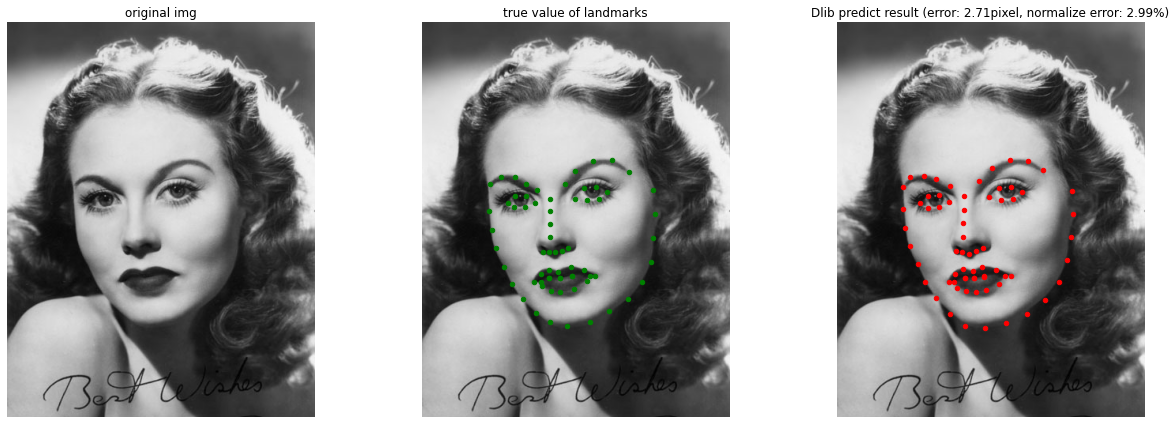

找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/lfpw/trainset/image_0116_mirror.pts
处理: image_0734.png


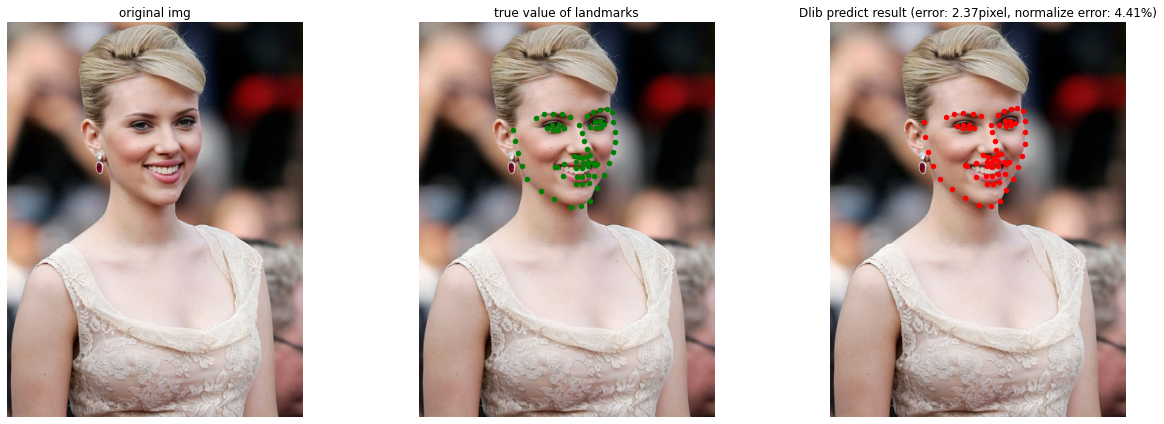


=====stat result=====
sample number: 2
average pixel error: 2.54 ± 0.17
average normalize error: 3.70% ± 0.71%


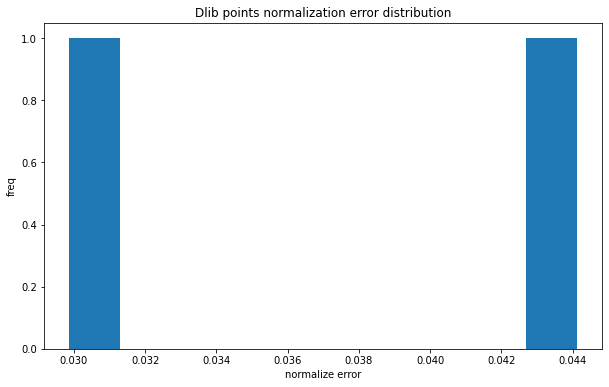


 subset verification: ibug
处理: image_102.jpg
未检测到人脸: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_102.jpg
处理: image_108.jpg


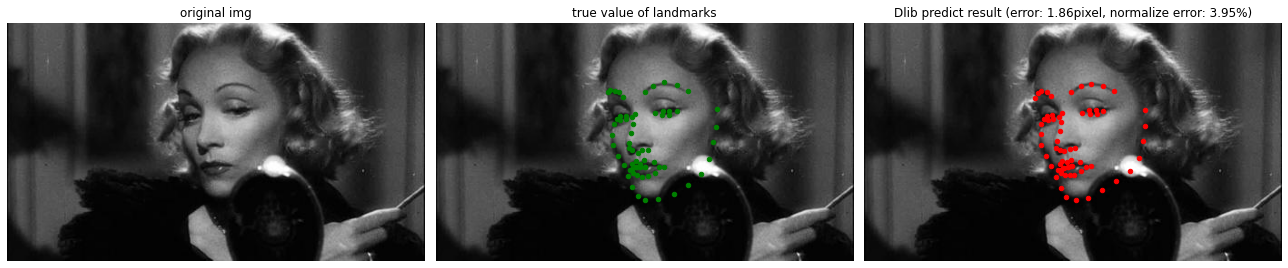

找不到对应的标志点文件: ../input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/ibug/image_092_mirror.pts

=====stat result=====
sample number: 1
average pixel error: 1.86 ± 0.00
average normalize error: 3.95% ± 0.00%


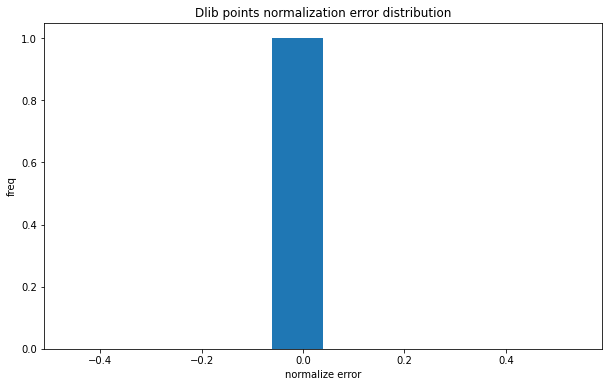

In [26]:
from pathlib import Path
import random
main()